In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import pygame
from algorithms.rl import RL
from algorithms.planner import Planner
from examples.test_env import TestEnv
from examples.grid_search import GridSearch
from examples.plots import Plots
import itertools
import time
import warnings
warnings.filterwarnings("ignore")

## Model-based learning: Value Iteration and Policy Iteration

In [2]:
def rl_train(mdp_problem, algorithm='Value Iteration', params={'n_iters': 1000}):
    if algorithm == 'Value Iteration':
        V, V_track, pi = Planner(mdp_problem.env.P).value_iteration(**params)
        return V, V_track, pi
    elif algorithm == 'Policy Iteration':
        V, V_track, pi = Planner(mdp_problem.env.P).policy_iteration(**params)
        return V, V_track, pi
    return None


def get_reward_simulation(mdp_problem, pi, simulations=50):
    test_scores = TestEnv.test_env(env=mdp_problem.env, render=False, user_input=False, pi=pi, n_iters=simulations)
    return sum(test_scores)


def iterate_rl_train(mdp_problem, algorithm, train_iterations=1000, simulations=50, params=None):
    results = pd.DataFrame(columns=['iteration', 'simulations', 'total_reward', 'performance_score'])
    for n in range(1, train_iterations):
        result = {}
        result['iteration'] = n
        result['simulations'] = simulations
        if params==None:
            params = {'n_iters': n}
        else:
            params['n_iters'] = n
        # Train algorithm
        V, V_track, pi = rl_train(mdp_problem, algorithm, params)
        # Get reward over simulations
        if sum(V) == 0:  # Case when model has not converged yet
            result['total_reward'] = 0
            result['performance_score'] = 0
        else:
            result['total_reward'] = get_reward_simulation(mdp_problem, pi)
            result['performance_score'] = result['total_reward'] / simulations
        results = results._append(result, ignore_index=True)
    return results


def get_convergence_plot(V_track, problem_name, algorithm, grid_size):
    V_track_max = []
    trained_iterations = V_track.shape[0]
    prev_max_V_track = 0
    for i in range(V_track.shape[0]):
        max_V_track = max(V_track[i])
        if max_V_track >= prev_max_V_track:
            V_track_max.append(max_V_track)
            prev_max_V_track = max_V_track
        if max_V_track < prev_max_V_track:
            trained_iterations = i
            break
    plt.plot(range(trained_iterations), V_track_max[:trained_iterations])
    plt.title(
        '%s-%dx%d - Convergence of V(s) using %s' % (problem_name, grid_size, grid_size, algorithm))
    plt.xlabel('iterations')
    plt.ylabel('V(s)')
    plt.show()


def get_policy_visual(pi, grid_size):
    action_dict = {0: 'left', 1: 'down', 2: 'right', 3: 'up'}
    action_digit_list = [[] for _ in range(grid_size)]
    action_desc_list = [[] for _ in range(grid_size)]
    for x in range(grid_size):
        for y in range(grid_size):
            i = x + y * grid_size
            action_digit_list[y].append(pi(i))
            action_desc_list[y].append(action_dict[pi(i)])
    return pd.DataFrame(action_desc_list)


def get_result_rl_algo(problem_name, grid_size, algorithm='Value Iteration', train_iterations=1000, simulations=50):
    print('\n%s-%dx%d - Algorithm: %s' % (problem_name, grid_size, grid_size, algorithm))
    # Define MDP problem
    map_name = str(grid_size) + "x" + str(grid_size)
    mdp_problem_params = {"map_name": map_name, "is_slippery": True}
    mdp_problem = gym.make(problem_name, **mdp_problem_params)

    # # Not sure if I'm going to use  this section...
    # result = iterate_rl_train(mdp_problem,
    #                           algorithm,
    #                           train_iterations=train_iterations,
    #                           simulations=simulations)
    # plt.plot(result['iteration'], result['total_reward'])

    # Train algorithm
    params = {'n_iters': train_iterations}
    V, V_track, pi = rl_train(mdp_problem, algorithm, params)
    # Get reward over simulations
    total_reward = get_reward_simulation(mdp_problem, pi, simulations)
    performance_score = total_reward / simulations
    # Get convergence plot
    get_convergence_plot(V_track, problem_name, algorithm, grid_size)
    # Get state values
    Plots.grid_values_heat_map(V, "State Values")
    df = get_policy_visual(pi, grid_size)
    print(df)
    print('Total rewards over %d simulations: %d (%.0f%%)' % (simulations, total_reward, performance_score*100))
    return V, V_track, pi, total_reward, performance_score


FrozenLake-v1-4x4 - Algorithm: Value Iteration


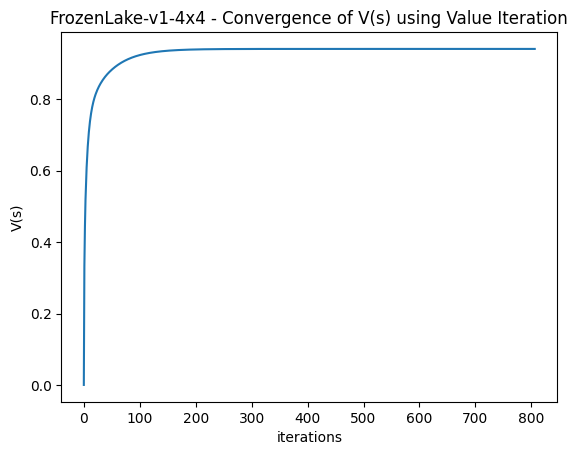

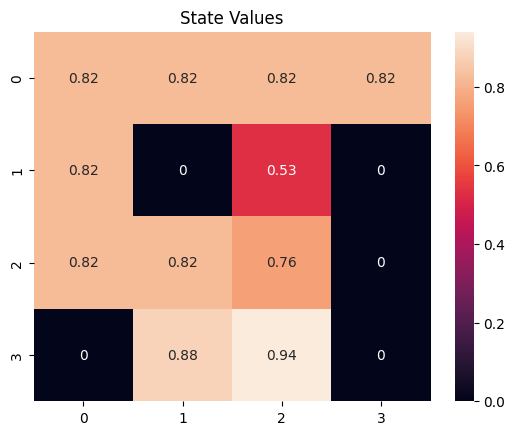

      0      1     2     3
0  left     up    up    up
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 166 (83%)

FrozenLake-v1-4x4 - Algorithm: Policy Iteration


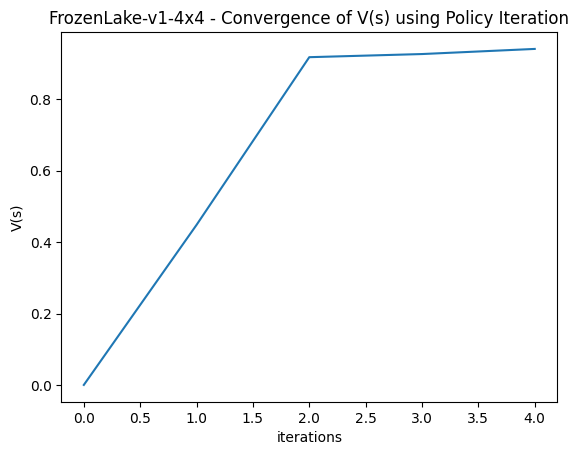

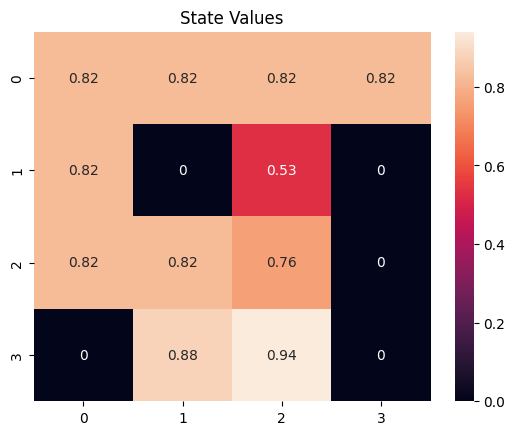

      0      1     2     3
0  left     up    up    up
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 163 (82%)

FrozenLake-v1-8x8 - Algorithm: Value Iteration


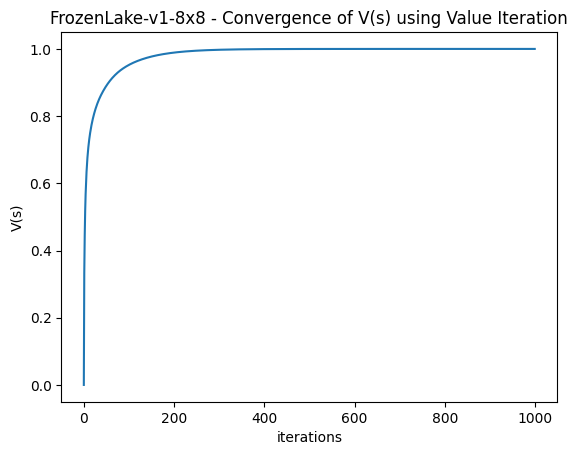

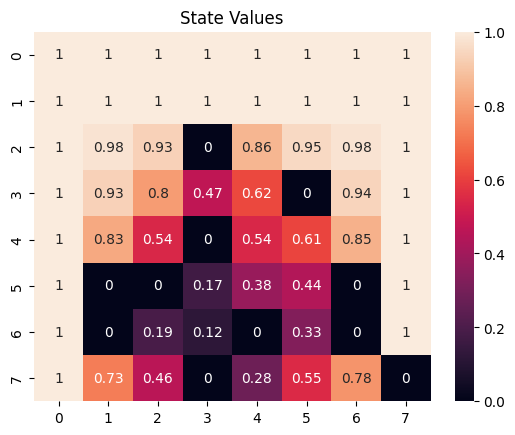

      0      1      2      3      4      5      6      7
0    up  right  right  right  right  right  right  right
1    up     up     up     up     up     up     up  right
2  left   left   left   left  right     up     up  right
3  left   left   left   down   left   left  right  right
4  left     up   left   left  right   down     up  right
5  left   left   left   down     up   left   left  right
6  left   left   down   left   left   left   left  right
7  left   down   left   left   down  right   down   left
Total rewards over 200 simulations: 200 (100%)

FrozenLake-v1-8x8 - Algorithm: Policy Iteration


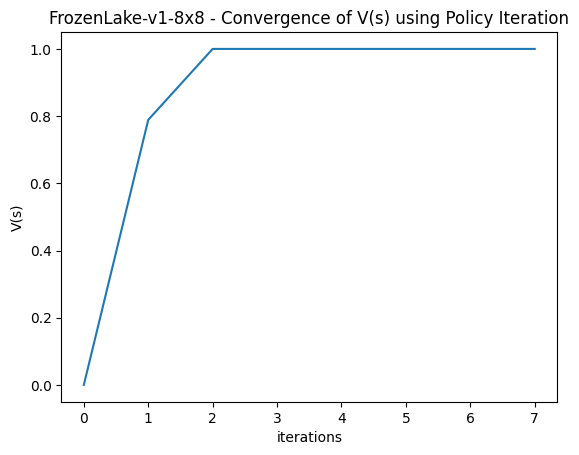

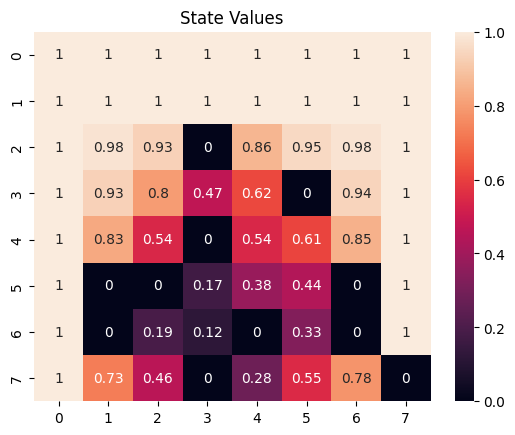

      0      1      2      3      4      5      6      7
0    up  right  right  right  right  right  right  right
1    up     up     up     up     up     up     up  right
2  left   left   left   left  right     up     up  right
3  left   left   left   down   left   left  right  right
4  left     up   left   left  right   down     up  right
5  left   left   left   down     up   left   left  right
6  left   left   down   left   left   left   left  right
7  left   down   left   left   down  right   down   left
Total rewards over 200 simulations: 200 (100%)


In [3]:
# Declare variables unique to MDP problem
PROBLEM_NAME = 'FrozenLake-v1'
GRID_SIZES = [4, 8]
ALGORITHMS = ['Value Iteration', 'Policy Iteration']
TRAIN_ITERATIONS = 1000
SIMULATIONS = 200

for grid_size in GRID_SIZES:
    for algorithm in ALGORITHMS:
        get_result_rl_algo(problem_name=PROBLEM_NAME, 
                           grid_size=grid_size, 
                           algorithm=algorithm, 
                           train_iterations=TRAIN_ITERATIONS, 
                           simulations=SIMULATIONS)

## Model-free learner: Q-learning

In [3]:
PROBLEM_NAME = 'FrozenLake-v1'
GRID_SIZES = [4, 8]
ALGORITHMS = ['Value Iteration', 'Policy Iteration']
TRAIN_ITERATIONS = 1000
SIMULATIONS = 200
EPSILON_DECAY = [.4, .7, .9]
ITERS = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]

In [4]:
def get_convergence_plot_qlearn(Q_track, problem_name, grid_size, algorithm):
    Q_track_avg = []
    trained_iterations = Q_track.shape[0]
    for i in range(Q_track.shape[0]):
        Q_track_avg.append(np.average(Q_track[i]))
    plt.plot(range(trained_iterations), Q_track_avg[:trained_iterations])
    plt.title(
        '%s-%dx%d - Convergence of Q(s) using %s' % (problem_name, grid_size, grid_size, algorithm))
    plt.xlabel('episodes')
    plt.ylabel('Q(s)')
    plt.show()

def get_result_q_learning_algo(problem_name, grid_size, epsilon, n_episode, simulations, algorithm='Q-Learning'):
    print('\n%s-%dx%d - Algorithm: %s' % (problem_name, grid_size, grid_size, algorithm))
    print("running -- with epsilon decay: ", epsilon, " episodes: ", n_episode)
    # Define MDP problem
    map_name = str(grid_size) + "x" + str(grid_size)
    mdp_problem_params = {"map_name": map_name, "is_slippery": True}
    mdp_problem = gym.make(problem_name, **mdp_problem_params)
    start = time.time()
    # Train Q-learner
    Q, V, pi, Q_track, pi_track = RL(mdp_problem.env).q_learning(epsilon_decay_ratio=epsilon, n_episodes=n_episode)
    end = time.time()
    print(np.sum(V))
    if np.sum(V) > 0.6:
        # Get reward over simulations
        total_reward = get_reward_simulation(mdp_problem, pi, simulations)
        performance_score = total_reward / simulations
    else:
        total_reward = 0
        performance_score = 0
    # Get convergence plot
    get_convergence_plot_qlearn(Q_track, problem_name, grid_size, algorithm)
    # Get state values
    Plots.grid_values_heat_map(V, "State Values")
    df = get_policy_visual(pi, grid_size)
    print(df)
    print('Total rewards over %d simulations: %d (%.0f%%)' % (simulations, total_reward, performance_score*100))
    run_time = end - start
    result = {}
    result['grid_size'] = grid_size
    result['epsilon'] = epsilon
    result['n_episodes'] = n_episode
    result['total_reward'] = total_reward
    result['simulations'] = simulations
    result['performance_score'] = performance_score
    result['run_time'] = run_time
    return Q, V, pi, Q_track, pi_track, result

def grid_search_q_learn(problem_name, grid_sizes, epsilons, n_episodes, simulations, algorithm='Q-Learning'):
    result_df = pd.DataFrame(columns=['grid_size', 'epsilon', 'n_episodes', 'total_reward', 'simulations', 'performance_score', 'run_time'])
    for grid in itertools.product(grid_sizes, epsilons, n_episodes):
        grid_size = grid[0]
        epsilon = grid[1]
        n_episode = grid[2]
        _, _, _, _, _, result = get_result_q_learning_algo(problem_name, 
                                                                         grid_size, 
                                                                         epsilon, 
                                                                         n_episode, 
                                                                         simulations, 
                                                                         algorithm='Q-Learning')
        result_df = result_df._append(result, ignore_index=True)
    return result_df

In [ ]:
ITERS = [500, 5000, 10000, 20000, 40000, 100000]
_, _, _, _, _, result = get_result_q_learning_algo(PROBLEM_NAME, 
                                                     grid_size=8, 
                                                     epsilon=0.4, 
                                                     n_episode=500, 
                                                     simulations = SIMULATIONS, 
                                                     algorithm='Q-Learning')
# result_df = grid_search_q_learn(problem_name=PROBLEM_NAME,
#                                 grid_sizes = [8], 
#                                 epsilons = EPSILON_DECAY, 
#                                 n_episodes = ITERS, 
#                                 simulations = SIMULATIONS, 
#                                 algorithm = 'Q-Learning')


FrozenLake-v1-8x8 - Algorithm: Q-Learning
running -- with epsilon decay:  0.4  episodes:  500


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(result_df)
result_df.to_csv('result_frozen_lake_8.csv')


FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.4  episodes:  500


runtime = 0.24 seconds


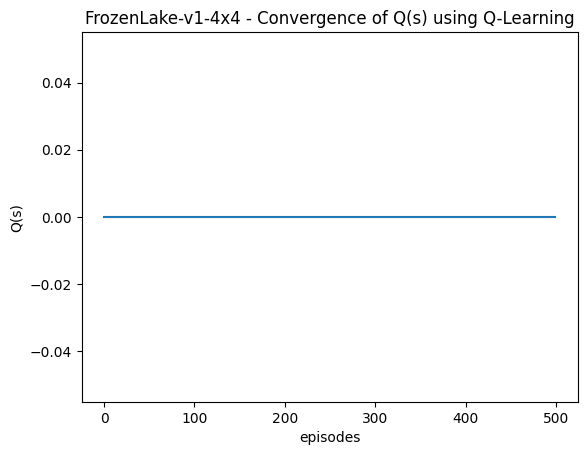

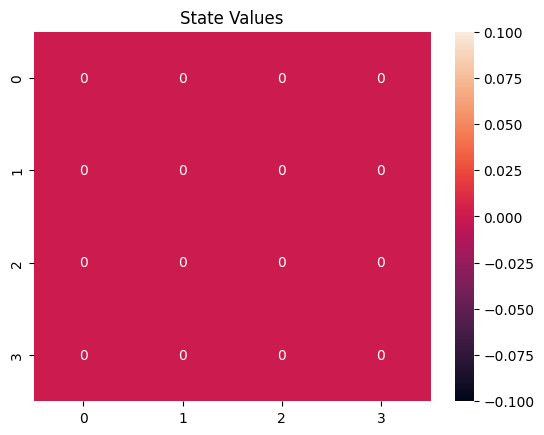

      0     1     2     3
0  left  left  left  left
1  left  left  left  left
2  left  left  left  left
3  left  left  left  left
Total rewards over 200 simulations: 0 (0%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.4  episodes:  1000


runtime = 0.41 seconds


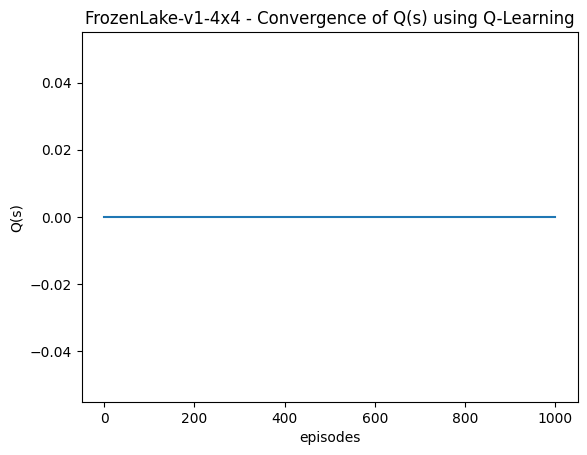

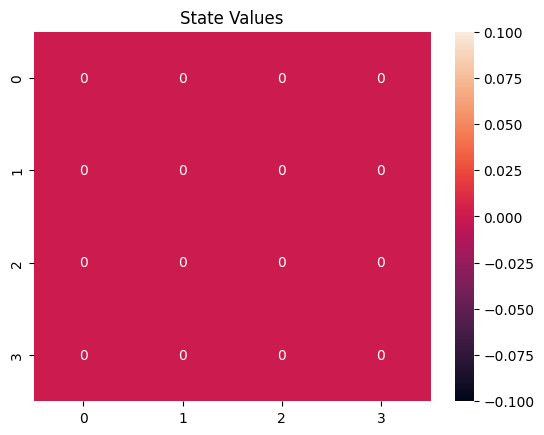

      0     1     2     3
0  left  left  left  left
1  left  left  left  left
2  left  left  left  left
3  left  left  left  left
Total rewards over 200 simulations: 0 (0%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.4  episodes:  2000


runtime = 1.60 seconds


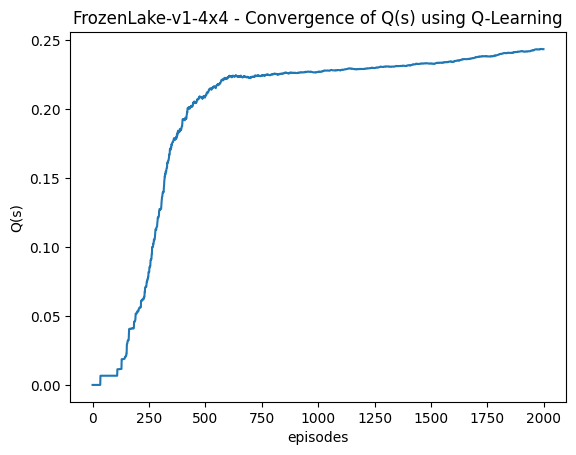

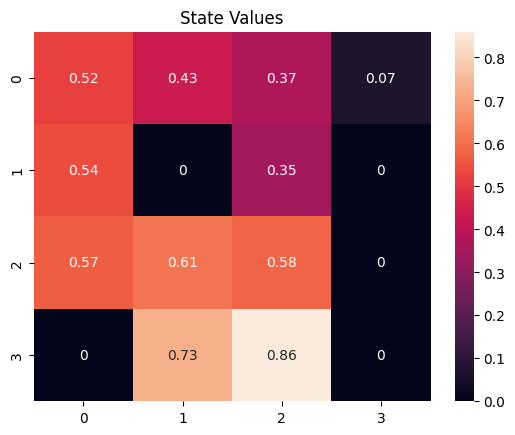

      0      1      2     3
0  left     up   left  left
1  left   left  right  left
2    up   down   left  left
3  left  right   down  left
Total rewards over 200 simulations: 153 (76%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.4  episodes:  3000


runtime = 2.08 seconds


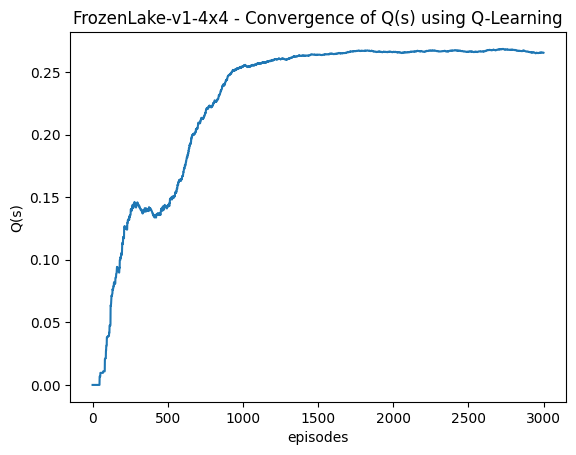

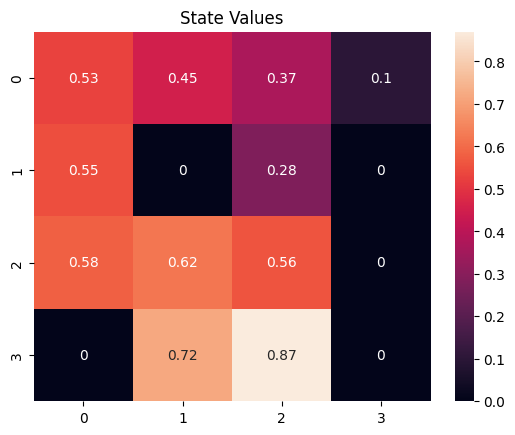

      0      1     2     3
0  left     up  left  down
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 159 (80%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.4  episodes:  4000


runtime = 2.98 seconds


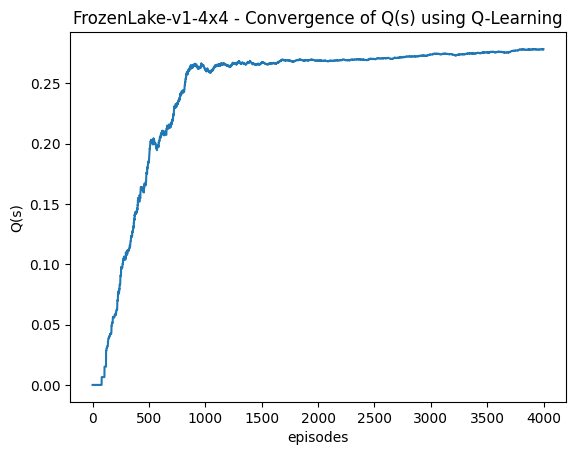

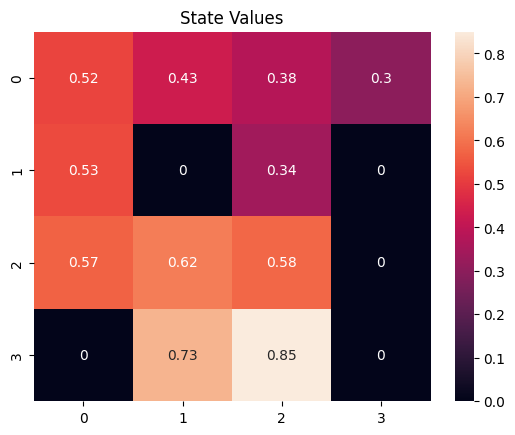

      0      1      2     3
0  left     up   left    up
1  left   left  right  left
2    up   down   left  left
3  left  right   down  left
Total rewards over 200 simulations: 160 (80%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.4  episodes:  5000


runtime = 3.91 seconds


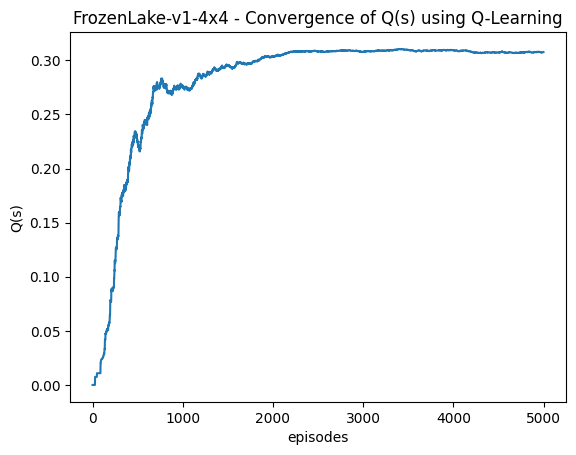

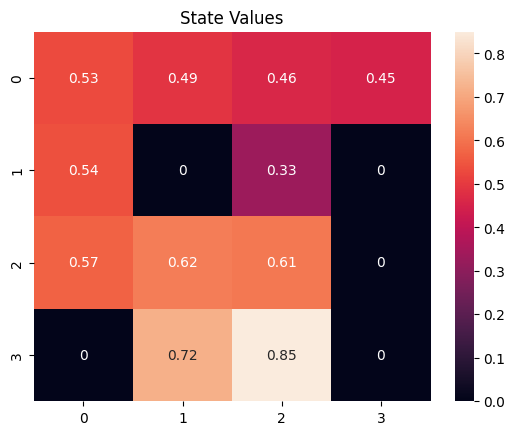

      0      1      2     3
0  left     up     up    up
1  left   left  right  left
2    up   down   left  left
3  left  right   down  left
Total rewards over 200 simulations: 167 (84%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.7  episodes:  500


runtime = 0.20 seconds


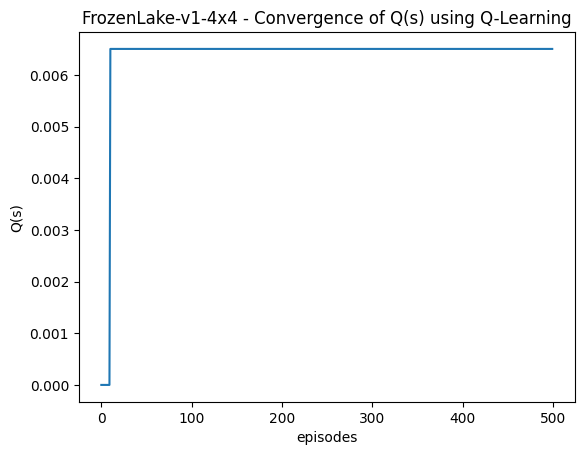

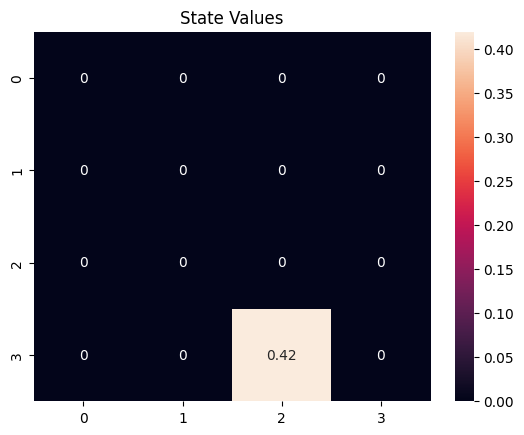

      0     1     2     3
0  left  left  left  left
1  left  left  left  left
2  left  left  left  left
3  left  left    up  left
Total rewards over 200 simulations: 0 (0%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.7  episodes:  1000


runtime = 0.22 seconds


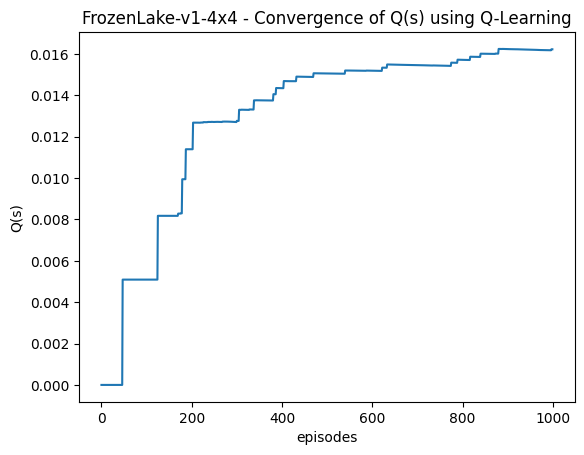

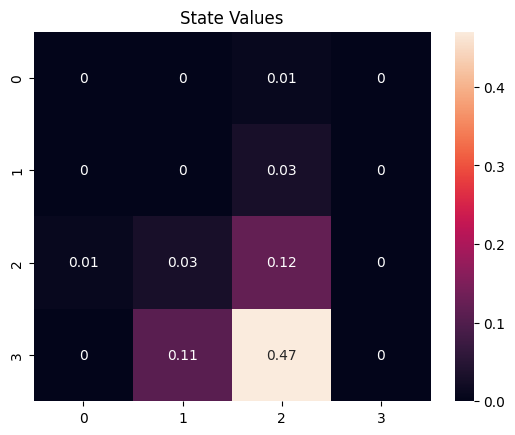

       0      1      2     3
0   left   down   left  left
1   down   left   left  left
2  right     up   left  left
3   left  right  right  left
Total rewards over 200 simulations: 8 (4%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.7  episodes:  2000


runtime = 1.33 seconds


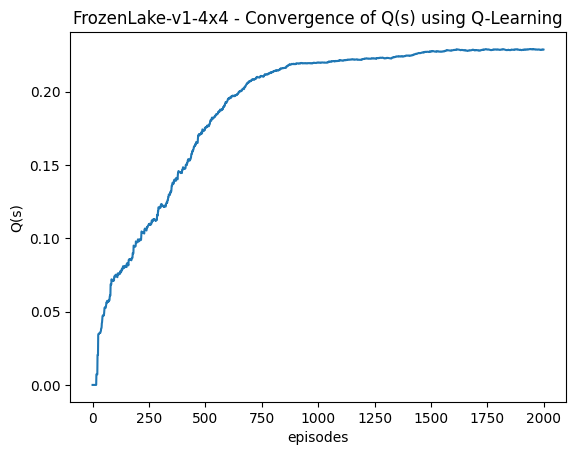

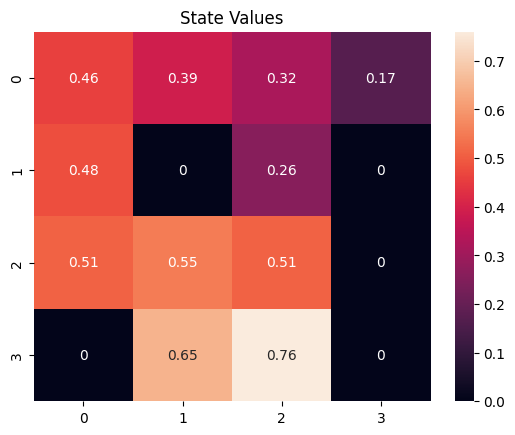

      0      1      2     3
0  left     up   left    up
1  left   left   left  left
2    up   down   left  left
3  left  right  right  left
Total rewards over 200 simulations: 146 (73%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.7  episodes:  3000


runtime = 2.00 seconds


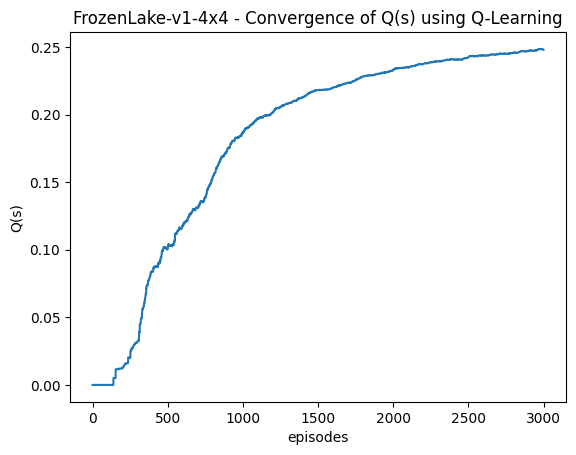

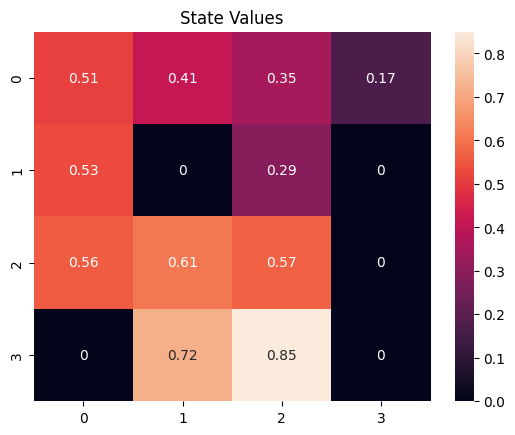

      0      1     2     3
0  left     up  left    up
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 146 (73%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.7  episodes:  4000


runtime = 3.00 seconds


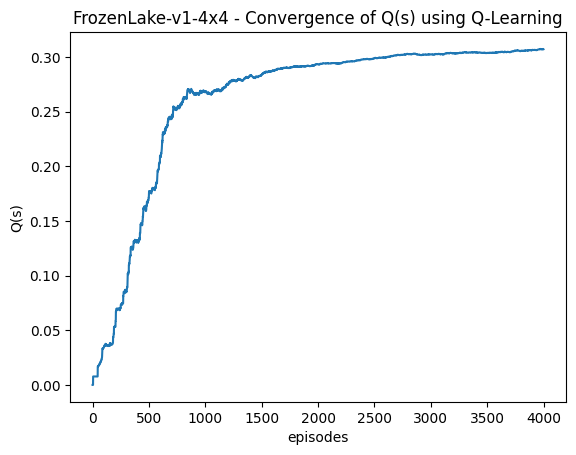

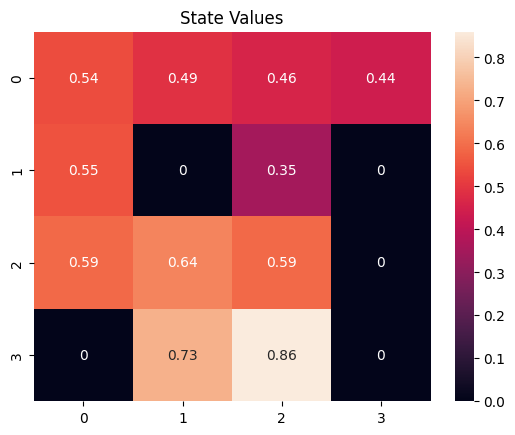

      0      1     2     3
0  left     up    up    up
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 168 (84%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.7  episodes:  5000


runtime = 3.65 seconds


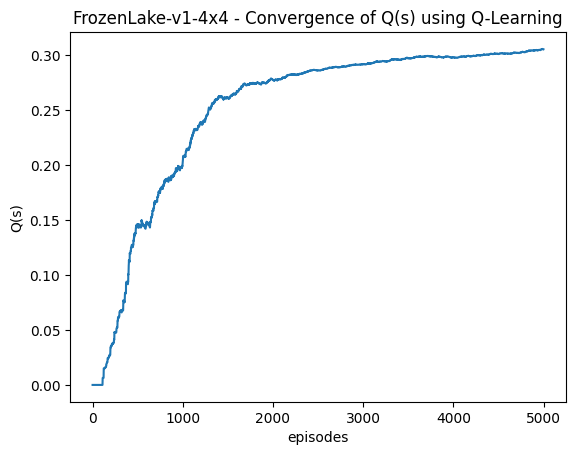

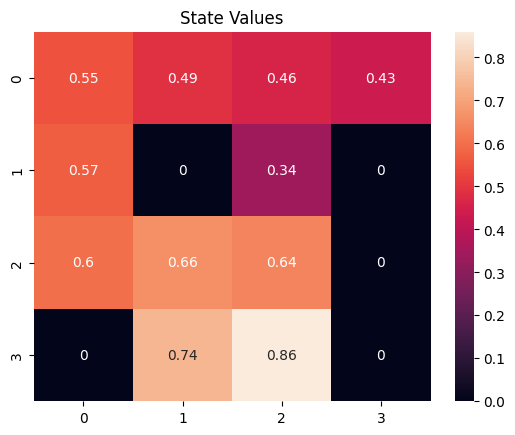

      0      1     2     3
0  left     up    up    up
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 160 (80%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.9  episodes:  500


runtime = 0.22 seconds


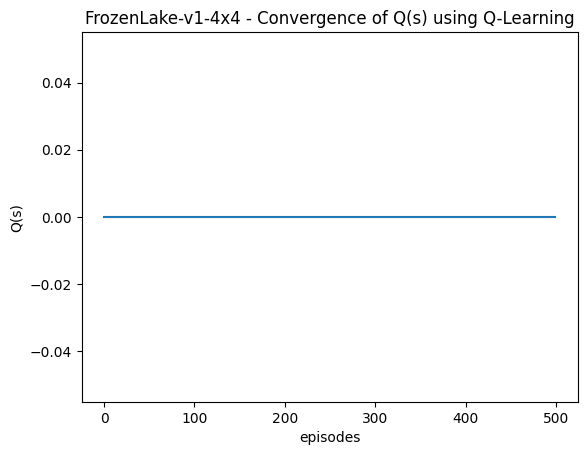

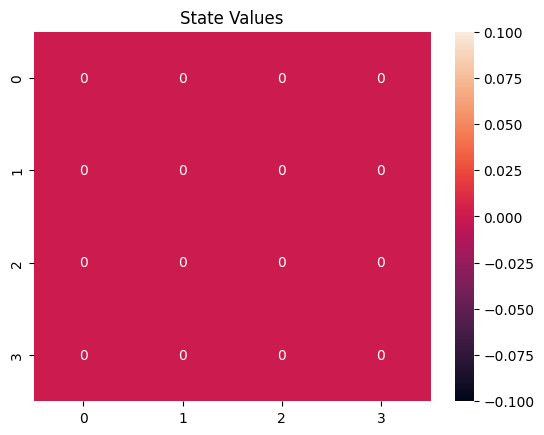

      0     1     2     3
0  left  left  left  left
1  left  left  left  left
2  left  left  left  left
3  left  left  left  left
Total rewards over 200 simulations: 0 (0%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.9  episodes:  1000


runtime = 0.35 seconds


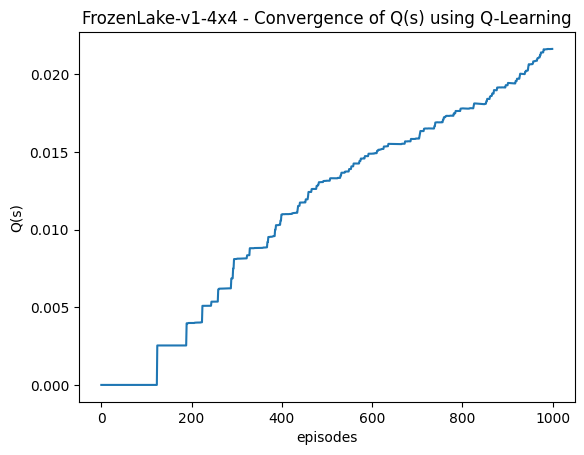

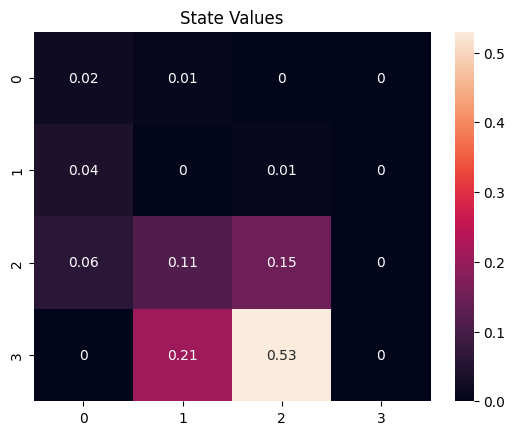

       0     1      2     3
0  right  left     up    up
1   left  left  right  left
2     up  down   left  left
3   left  down   down  left
Total rewards over 200 simulations: 18 (9%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.9  episodes:  2000


runtime = 1.23 seconds


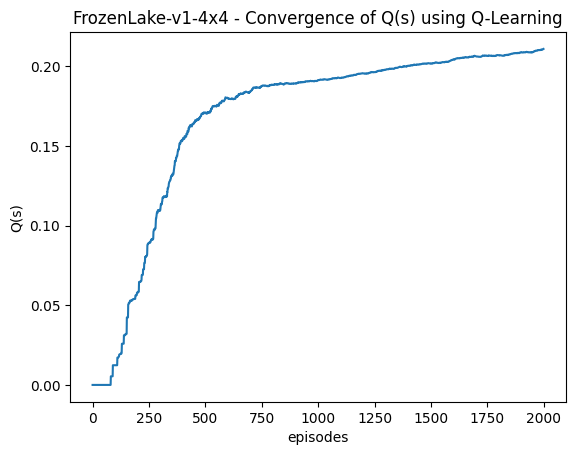

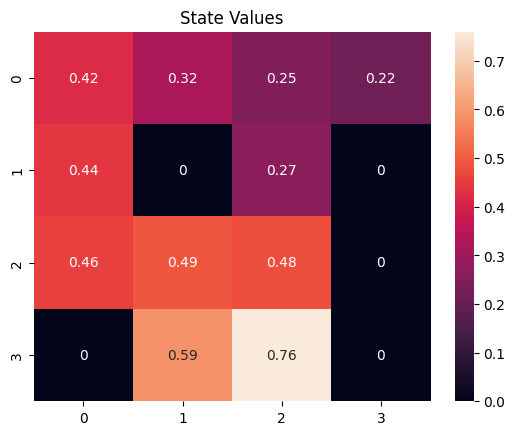

      0      1      2     3
0  left     up   down    up
1  left   left   left  left
2    up   down   left  left
3  left  right  right  left
Total rewards over 200 simulations: 127 (64%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.9  episodes:  3000


runtime = 1.91 seconds


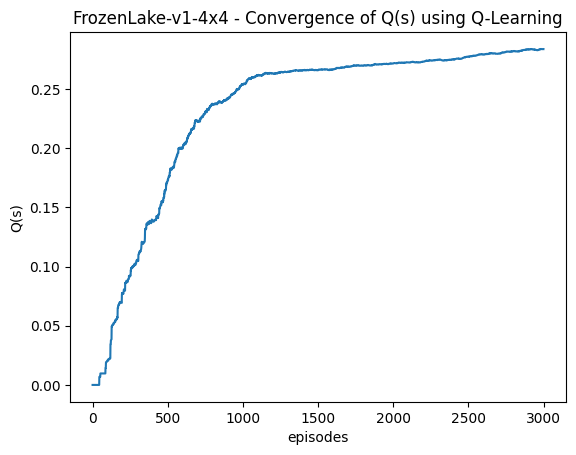

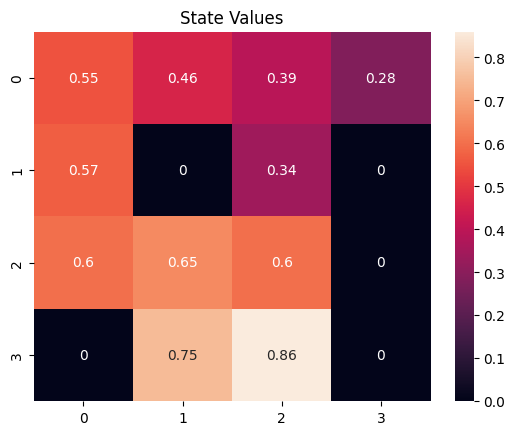

      0      1     2     3
0  left     up  left    up
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 164 (82%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.9  episodes:  4000


runtime = 2.72 seconds


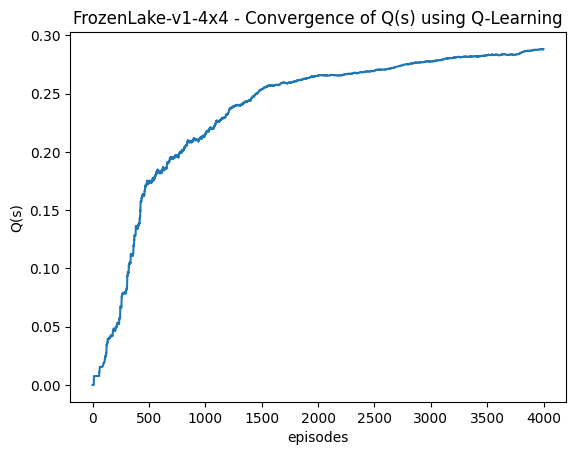

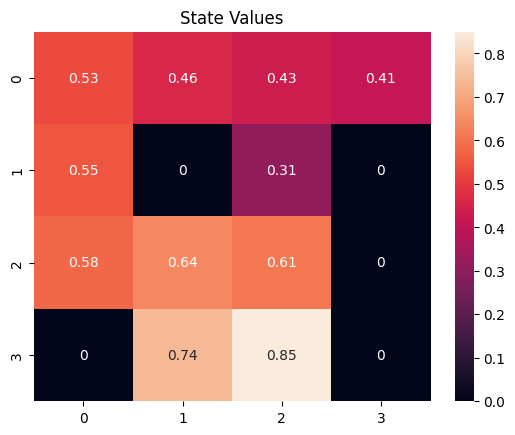

      0      1     2     3
0  left     up    up    up
1  left   left  left  left
2    up   down  left  left
3  left  right  down  left
Total rewards over 200 simulations: 167 (84%)

FrozenLake-v1-4x4 - Algorithm: Q-Learning
running -- with epsilon decay:  0.9  episodes:  5000


runtime = 3.39 seconds


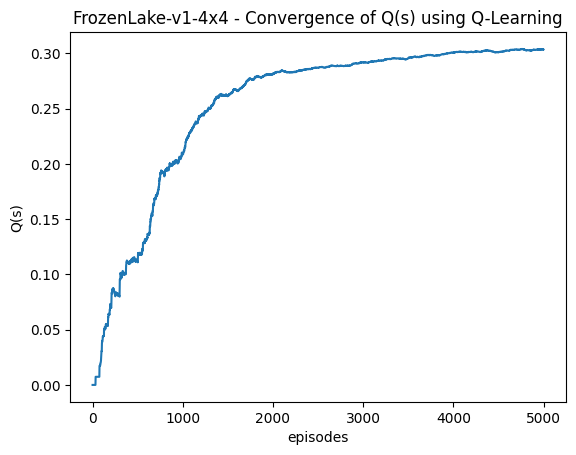

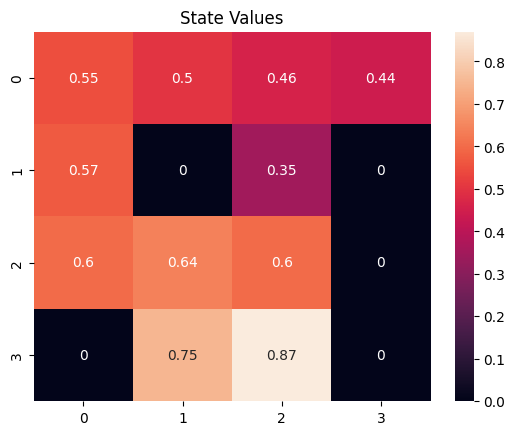

      0      1      2     3
0  left     up     up    up
1  left   left  right  left
2    up   down   left  left
3  left  right   down  left
Total rewards over 200 simulations: 165 (82%)


In [15]:
EPSILON_DECAY = [.4, .7, .9]
ITERS = [500, 1000, 2000, 3000, 4000, 5000]
result_df = grid_search_q_learn(problem_name=PROBLEM_NAME,
                                grid_sizes = [4], 
                                epsilons = EPSILON_DECAY, 
                                n_episodes = ITERS, 
                                simulations = SIMULATIONS, 
                                algorithm = 'Q-Learning')

In [16]:
# print(result_df)
# result_df.to_csv('result_frozen_lake_4.csv')

    grid_size  epsilon  n_episodes  total_reward  simulations   
0         4.0      0.4       500.0           0.0        200.0  \
1         4.0      0.4      1000.0           0.0        200.0   
2         4.0      0.4      2000.0         153.0        200.0   
3         4.0      0.4      3000.0         159.0        200.0   
4         4.0      0.4      4000.0         160.0        200.0   
5         4.0      0.4      5000.0         167.0        200.0   
6         4.0      0.7       500.0           0.0        200.0   
7         4.0      0.7      1000.0           8.0        200.0   
8         4.0      0.7      2000.0         146.0        200.0   
9         4.0      0.7      3000.0         146.0        200.0   
10        4.0      0.7      4000.0         168.0        200.0   
11        4.0      0.7      5000.0         160.0        200.0   
12        4.0      0.9       500.0           0.0        200.0   
13        4.0      0.9      1000.0          18.0        200.0   
14        4.0      0.9   